# Question Clustering in Python

In [15]:
from download import download_squad, collect_squad_data, download_fasttext, download_infersent, build_infersent_model
import numpy as np
import pandas as pd
from plotting import PlotWordCloudArray
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

In [16]:
# download_squad()
# download_fasttext()
# download_infersent()

In [17]:
squadJson = collect_squad_data()

In [18]:
# print SQuAD structure
for subject in squadJson['data'][:1]:
    print("\nTitle: {0}\n".format(subject['title']))
    for paragraph in subject['paragraphs'][:2]:
        print("\tContext: {0}\n".format(paragraph['context']))
        for qa in paragraph['qas'][:2]:
            print("\tQuestion: {0}\n".format(qa['question']))
            print("\tAnswer: {0}\n".format(qa['answers']))


Title: University_of_Notre_Dame

	Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

	Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

	Answer: [{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}]

	Question: What is in front of the Notre Dame Main Building?

	Answer: [{'answer_start': 188, 'text': '

## Question Corpus

In [19]:
questions = [{'question':qa['question'],'paragraph':p,'subject':subject['title']}
                 for subject in squadJson['data']
                 for p,paragraph in enumerate(subject['paragraphs'])
                 for qa in paragraph['qas']] 
questions = pd.DataFrame(questions)

subject_dict={s:i for i,s in enumerate(questions['subject'].unique())}
questions=questions.assign(subject_id = [subject_dict[s] for s in questions['subject']])

questions=questions.assign(paragraph = [s+'_'+str(p) for s,p in zip(questions['subject'],questions['paragraph'])])
paragraph_dict={s:i for i,s in enumerate(questions['paragraph'].unique())}
questions=questions.assign(paragraph_id = [paragraph_dict[p] for p in questions['paragraph']])

questions.head()

,question,paragraph,subject,subject_id,paragraph_id
0,To whom did the Virgin Mary allegedly appear i...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0
1,What is in front of the Notre Dame Main Building?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0
2,The Basilica of the Sacred heart at Notre Dame...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0
3,What is the Grotto at Notre Dame?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0
4,What sits on top of the Main Building at Notre...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0


## Question Encoding
### Infersent

In [20]:
# load pre-trained model
model=build_infersent_model()

# encode questions as vectors 
questions['encoding'] = list(model.encode(questions['question'], bsize=128, tokenize=False, verbose=False))
questions.head()

Vocab size : 100000.0


C:\Users\Mille\Documents\GitHub\millerdw.github.io\_notebooks\FindingTheWords_5\models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


,question,paragraph,subject,subject_id,paragraph_id,encoding
0,To whom did the Virgin Mary allegedly appear i...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, 0.024210334, 0.06961634, -0.017..."
1,What is in front of the Notre Dame Main Building?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.033483393, 0.0405459, -0.007..."
2,The Basilica of the Sacred heart at Notre Dame...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.04394476, 0.1438594, -0.0097..."
3,What is the Grotto at Notre Dame?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.021135122, 0.089850366, -0.0..."
4,What sits on top of the Main Building at Notre...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.025151305, 0.08926863, 0.000..."


## Clustering

In [21]:
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.preprocessing import RobustScaler
# from sklearn.tree import DecisionTreeRegressor
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [22]:
# filter dataset to first 10 topics
subdataset=questions[questions['subject'].isin(questions['subject'].unique()[:10])]

### High Level k-Means Clustering

In [23]:
# build training set array from encodings
X_train = np.stack(subdataset['encoding'])
X_train.shape

(3286, 4096)

In [24]:
# compute k-Means clustering
kmeans_high = KMeans(n_clusters=10, random_state=0).fit(X_train)
subdataset = subdataset.assign(high_label = kmeans_high.labels_)
subdataset.head()

,question,paragraph,subject,subject_id,paragraph_id,encoding,high_label
0,To whom did the Virgin Mary allegedly appear i...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, 0.024210334, 0.06961634, -0.017...",4
1,What is in front of the Notre Dame Main Building?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.033483393, 0.0405459, -0.007...",7
2,The Basilica of the Sacred heart at Notre Dame...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.04394476, 0.1438594, -0.0097...",7
3,What is the Grotto at Notre Dame?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.021135122, 0.089850366, -0.0...",7
4,What sits on top of the Main Building at Notre...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.025151305, 0.08926863, 0.000...",7


In [25]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, kmeans_high.labels_))
print("Adjusted Random Score: %0.3f" % adjusted_rand_score(subdataset['subject_id'], kmeans_high.labels_))
print("Homogeneity: %0.3f" % homogeneity_score(subdataset['subject_id'], kmeans_high.labels_))
print("Completeness: %0.3f" % completeness_score(subdataset['subject_id'], kmeans_high.labels_))
print("V-Measure: %0.3f" % v_measure_score(subdataset['subject_id'], kmeans_high.labels_))

Silhouette Coefficient: 0.058
Adjusted Random Score: 0.284
Homogeneity: 0.381
Completeness: 0.356
V-Measure: 0.368


In [26]:
# print clusters
for label in range(10):
    display(Markdown("\n**Cluster {0}**:".format(label)))
    qs=subdataset[subdataset['high_label']==label][:10]
    display(Markdown(qs[['high_label','paragraph','question']].to_markdown(index=False)))
    


**Cluster 0**:

|   high_label | paragraph                   | question                                                                                                                                  |
|-------------:|:----------------------------|:------------------------------------------------------------------------------------------------------------------------------------------|
|            0 | University_of_Notre_Dame_19 | Those who attended a Jesuit college may have been forbidden from joining which Law School due to the curricula at the Jesuit institution? |
|            0 | University_of_Notre_Dame_37 | What caused many intellectual Catholics to leave europe in the 1930s?                                                                     |
|            0 | University_of_Notre_Dame_44 | There were protested as a part of the construction at Eddy Street Commons, they came due tot he hiring of whom?                           |
|            0 | University_of_Notre_Dame_46 | Where did the Fighting Irish hockey team compete prior to a move to Hockey East, in terms of conference?                                  |
|            0 | Beyoncé_5                   | In what year did Beyonce's father quit his job to manage her group?                                                                       |
|            0 | Beyoncé_8                   | What album caused a lawsuit to be filed in 2001?                                                                                          |
|            0 | Beyoncé_43                  | Her alter ego was born when according to Beyonce?                                                                                         |
|            0 | Beyoncé_49                  | Which professor from Northeastern University wrote about how race correlates with these criticisms of Beyonce?                            |
|            0 | Beyoncé_49                  | In addition to her light skin color, what else has made part of the African American community criticize Beyoncé?                         |
|            0 | Beyoncé_49                  | In 2007, which music professor said he believes this criticism does involve race as well?                                                 |


**Cluster 1**:

|   high_label | paragraph                   | question                                                                        |
|-------------:|:----------------------------|:--------------------------------------------------------------------------------|
|            1 | University_of_Notre_Dame_2  | Which prize did Frederick Buechner create?                                      |
|            1 | University_of_Notre_Dame_10 | What program did John Augustine Zahm come to co-direct at Nore Dame?            |
|            1 | University_of_Notre_Dame_10 | What book did John Zahm write in 1896?                                          |
|            1 | University_of_Notre_Dame_37 | Who did Waldemar Gurian receive his tutelage under while seeking his doctorate? |
|            1 | University_of_Notre_Dame_41 | Which individual offered land to Father Edward Sorin?                           |
|            1 | University_of_Notre_Dame_41 | Which church was Father Edward Sorin representing?                              |
|            1 | University_of_Notre_Dame_45 | What does the acronym NCAA stand for?                                           |
|            1 | University_of_Notre_Dame_52 | In what year did "Notre Dame Victory March" get copyrighted?                    |
|            1 | University_of_Notre_Dame_53 | Ronald Reagan had a nickname, what was it?                                      |
|            1 | University_of_Notre_Dame_53 | Who starred as Daniel Ruettiger in the film Rudy?                               |


**Cluster 2**:

|   high_label | paragraph                   | question                                                                           |
|-------------:|:----------------------------|:-----------------------------------------------------------------------------------|
|            2 | University_of_Notre_Dame_3  | How many departments are within the Stinson-Remick Hall of Engineering?            |
|            2 | University_of_Notre_Dame_14 | What threat does the Global Adaptation Index study?                                |
|            2 | University_of_Notre_Dame_37 | What field of study did Anton-Hermann Chroust specialize in?                       |
|            2 | University_of_Notre_Dame_41 | Which structure was the first used for the purposes of the college?                |
|            2 | University_of_Notre_Dame_43 | How many programs did NDtv feature in 2002?                                        |
|            2 | University_of_Notre_Dame_49 | Against which opponent did Knute Rockne tell his team to "win one for the Gipper?" |
|            2 | Beyoncé_2                   | In her music, what are some recurring elements in them?                            |
|            2 | Beyoncé_8                   | Their third album, Survivor, sold how many during its first week?                  |
|            2 | Beyoncé_9                   | Which other song from the soundtrack did better in the charts?                     |
|            2 | Beyoncé_10                  | How many has "Dangerously in Love" sould worldwide since its debut?                |


**Cluster 3**:

|   high_label | paragraph                   | question                                                                     |
|-------------:|:----------------------------|:-----------------------------------------------------------------------------|
|            3 | University_of_Notre_Dame_2  | Where is the headquarters of the Congregation of the Holy Cross?             |
|            3 | University_of_Notre_Dame_2  | What is the primary seminary of the Congregation of the Holy Cross?          |
|            3 | University_of_Notre_Dame_7  | Which artist created the mural on the Theodore M. Hesburgh Library?          |
|            3 | University_of_Notre_Dame_10 | What was the lifespan of John Augustine Zahm?                                |
|            3 | University_of_Notre_Dame_13 | What was the Review of Politics inspired by?                                 |
|            3 | University_of_Notre_Dame_14 | The Kellogg Institute for International Studies is part of which university? |
|            3 | University_of_Notre_Dame_17 | What is Congregation of Holy Cross in Latin?                                 |
|            3 | University_of_Notre_Dame_24 | What was the lifespan of Theodore Hesburgh?                                  |
|            3 | University_of_Notre_Dame_31 | Gustavo Gutierrez is faculty of which institute?                             |
|            3 | University_of_Notre_Dame_33 | What was Notre Dame's first college?                                         |


**Cluster 4**:

|   high_label | paragraph                   | question                                                                             |
|-------------:|:----------------------------|:-------------------------------------------------------------------------------------|
|            4 | University_of_Notre_Dame_0  | To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?              |
|            4 | University_of_Notre_Dame_6  | In what year was the Joan B. Kroc Institute for International Peace Studies founded? |
|            4 | University_of_Notre_Dame_11 | Which professor sent the first wireless message in the USA?                          |
|            4 | University_of_Notre_Dame_11 | In what year did Jerome Green send his first wireless message?                       |
|            4 | University_of_Notre_Dame_20 | In what year did the team lead by Knute Rockne win the Rose Bowl?                    |
|            4 | University_of_Notre_Dame_30 | How many books are housed at the Theodore Hesburgh Library?                          |
|            4 | University_of_Notre_Dame_41 | In what year was Father Edward Sorin given two years to create a college?            |
|            4 | University_of_Notre_Dame_42 | In what year did the original Sorin built Main Building get replaced?                |
|            4 | University_of_Notre_Dame_45 | In what conference did the Fighting Irish take part in in 2012?                      |
|            4 | University_of_Notre_Dame_46 | To what conference did the Fighting Irish go after the Big East?                     |


**Cluster 5**:

|   high_label | paragraph         | question                                                                      |
|-------------:|:------------------|:------------------------------------------------------------------------------|
|            5 | Beyoncé_8         | What French composer wrote the original opera ''Carmen'' in the 19th century? |
|            5 | Frédéric_Chopin_0 | What year was Chopin born?                                                    |
|            5 | Frédéric_Chopin_0 | What era was Chopin active during?                                            |
|            5 | Frédéric_Chopin_0 | Where did Chopin grow up?                                                     |
|            5 | Frédéric_Chopin_0 | At what age did Chopin  leave Poland?                                         |
|            5 | Frédéric_Chopin_0 | When did Chopin die?                                                          |
|            5 | Frédéric_Chopin_0 | Chopin was active during what era?                                            |
|            5 | Frédéric_Chopin_0 | In what year was Chopin born?                                                 |
|            5 | Frédéric_Chopin_0 | In what city was Chopin born and raised?                                      |
|            5 | Frédéric_Chopin_0 | How old was Chopin when he left Poland?                                       |


**Cluster 6**:

|   high_label | paragraph   | question                                                         |
|-------------:|:------------|:-----------------------------------------------------------------|
|            6 | Beyoncé_0   | When did Beyonce start becoming popular?                         |
|            6 | Beyoncé_0   | What areas did Beyonce compete in when she was growing up?       |
|            6 | Beyoncé_0   | When did Beyonce leave Destiny's Child and become a solo singer? |
|            6 | Beyoncé_0   | In what city and state did Beyonce  grow up?                     |
|            6 | Beyoncé_0   | In which decade did Beyonce become famous?                       |
|            6 | Beyoncé_0   | In what city did Beyonce grow up?                                |
|            6 | Beyoncé_0   | On what date was Beyonce born?                                   |
|            6 | Beyoncé_0   | When did Beyoncé rise to fame?                                   |
|            6 | Beyoncé_0   | What role did Beyoncé have in Destiny's Child?                   |
|            6 | Beyoncé_0   | What was the first album Beyoncé released as a solo artist?      |


**Cluster 7**:

|   high_label | paragraph                  | question                                                                         |
|-------------:|:---------------------------|:---------------------------------------------------------------------------------|
|            7 | University_of_Notre_Dame_0 | What is in front of the Notre Dame Main Building?                                |
|            7 | University_of_Notre_Dame_0 | The Basilica of the Sacred heart at Notre Dame is beside to which structure?     |
|            7 | University_of_Notre_Dame_0 | What is the Grotto at Notre Dame?                                                |
|            7 | University_of_Notre_Dame_0 | What sits on top of the Main Building at Notre Dame?                             |
|            7 | University_of_Notre_Dame_1 | When did the Scholastic Magazine of Notre dame begin publishing?                 |
|            7 | University_of_Notre_Dame_1 | How often is Notre Dame's the Juggler published?                                 |
|            7 | University_of_Notre_Dame_1 | What is the daily student paper at Notre Dame called?                            |
|            7 | University_of_Notre_Dame_1 | How many student news papers are found at Notre Dame?                            |
|            7 | University_of_Notre_Dame_1 | In what year did the student paper Common Sense begin publication at Notre Dame? |
|            7 | University_of_Notre_Dame_2 | What is the oldest structure at Notre Dame?                                      |


**Cluster 8**:

|   high_label | paragraph                   | question                                      |
|-------------:|:----------------------------|:----------------------------------------------|
|            8 | University_of_Notre_Dame_5  | What type of degree is an M.Div.?             |
|            8 | University_of_Notre_Dame_6  | To whom was John B. Kroc married?             |
|            8 | University_of_Notre_Dame_6  | What company did Ray Kroc own?                |
|            8 | University_of_Notre_Dame_37 | What was Ivan Meštrović known for being?      |
|            8 | Beyoncé_0                   | Who managed the Destiny's Child group?        |
|            8 | Beyoncé_0                   | What is Beyonce's full name?                  |
|            8 | Beyoncé_0                   | What was Beyoncé's role in Destiny's Child?   |
|            8 | Beyoncé_1                   | What is the name of Beyoncé's alter-ego?      |
|            8 | Beyoncé_3                   | What race was Beyonce's father?               |
|            8 | Beyoncé_3                   | What is the name of Beyoncé's younger sister? |


**Cluster 9**:

|   high_label | paragraph          | question                                                                            |
|-------------:|:-------------------|:------------------------------------------------------------------------------------|
|            9 | Beyoncé_53         | How many certifications did RIAA give Beyoncé?                                      |
|            9 | Beyoncé_56         | The world's best selling celebrity perfume line belongs to whom?                    |
|            9 | Beyoncé_58         | What type of clothing does Parkwood Topshop Athletic Ltd produce?                   |
|            9 | Frédéric_Chopin_41 | How many known works of Chopin's music were on YouTube up to the beginning of 2014? |
|            9 | Frédéric_Chopin_57 | Chopin's Polish dance music was developed for what type of hall?                    |
|            9 | IPod_0             | When was the original iPod released?                                                |
|            9 | IPod_0             | How many different types of iPod are currently available?                           |
|            9 | IPod_0             | The iPod Touch uses what kind of interface?                                         |
|            9 | IPod_0             | In what year was the first iPod released?                                           |
|            9 | IPod_0             | How many versions of the iPod currently exist?                                      |

In [27]:
X_train_tsne = TSNE(n_components=2).fit_transform(X_train)

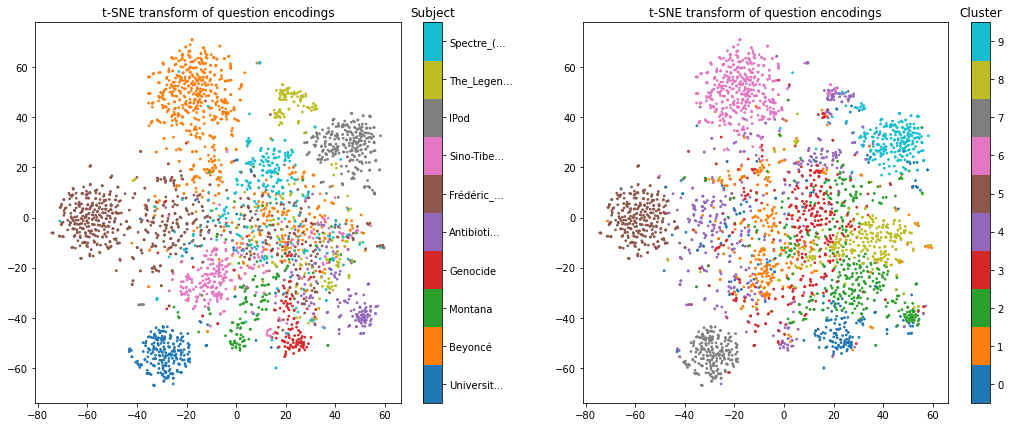

In [29]:
fig,ax=plt.subplots(1,2,figsize=(18,7))


im=ax[0].scatter(x=X_train_tsne[:,0],
                 y=X_train_tsne[:,1],
                 s=3,
                 c=subdataset['subject_id'],
                 cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5)
ax[0].set_title('t-SNE transform of question encodings')
cbar=fig.colorbar(im, ax=ax.ravel()[0], ticks=[*range(10)])
cbar.ax.set_yticklabels([list(subject_dict.keys())[i][:9]+('...' if len(list(subject_dict.keys())[i])>9 else '') for i in range(10)])
cbar.ax.set_title('Subject')

im=ax[1].scatter(x=X_train_tsne[:,0],
                 y=X_train_tsne[:,1],
                 s=3,
                 c=subdataset['high_label'],
                 cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5)
ax[1].set_title('t-SNE transform of question encodings')
cbar=fig.colorbar(im, ax=ax.ravel()[1], ticks=[*range(10)])
cbar.ax.set_title('Cluster')

plt.show()

Type of question rather than question context, data shift



Juding by eye, however we need to be careful. #t-SNE can be used to make lot

Clusters 5,6,7, and 9 are relatively self contained and consistent


Remember word clouds are limited to the top 10 subjects

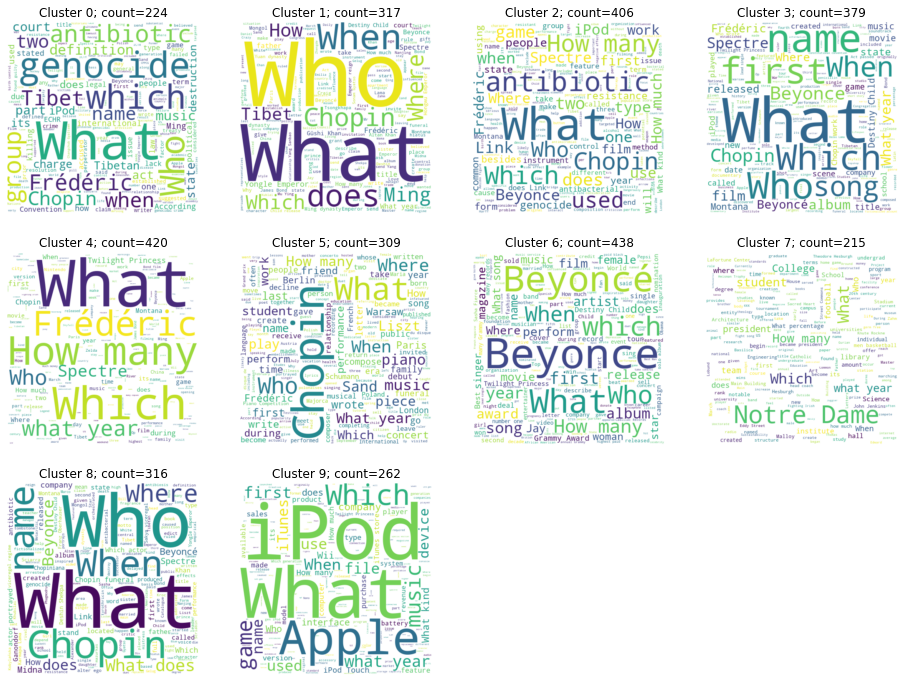

In [30]:
Ks = np.array([np.array([0,1,2,3]), np.array([4,5,6,7]), np.array([8,9,None,None])])
PlotWordCloudArray(subdataset['question'],subdataset['high_label'],Ks)

### Low-Level

In [31]:
kmeans_low = KMeans(n_clusters=100, random_state=0).fit(X_train)
subdataset = subdataset.assign(low_label = kmeans_low.labels_)
subdataset.head()

,question,paragraph,subject,subject_id,paragraph_id,encoding,high_label,low_label
0,To whom did the Virgin Mary allegedly appear i...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, 0.024210334, 0.06961634, -0.017...",4,64
1,What is in front of the Notre Dame Main Building?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.033483393, 0.0405459, -0.007...",7,50
2,The Basilica of the Sacred heart at Notre Dame...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.04394476, 0.1438594, -0.0097...",7,50
3,What is the Grotto at Notre Dame?,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.021135122, 0.089850366, -0.0...",7,19
4,What sits on top of the Main Building at Notre...,University_of_Notre_Dame_0,University_of_Notre_Dame,0,0,"[0.0074688913, -0.025151305, 0.08926863, 0.000...",7,50


In [32]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, kmeans_low.labels_))
print("Adjusted Random Score: %0.3f" % adjusted_rand_score(subdataset['subject_id'], kmeans_low.labels_))
print("Homogeneity: %0.3f" % homogeneity_score(subdataset['subject_id'], kmeans_low.labels_))
print("Completeness: %0.3f" % completeness_score(subdataset['subject_id'], kmeans_low.labels_))
print("V-Measure: %0.3f" % v_measure_score(subdataset['subject_id'], kmeans_low.labels_))

Silhouette Coefficient: 0.024
Adjusted Random Score: 0.077
Homogeneity: 0.619
Completeness: 0.294
V-Measure: 0.399


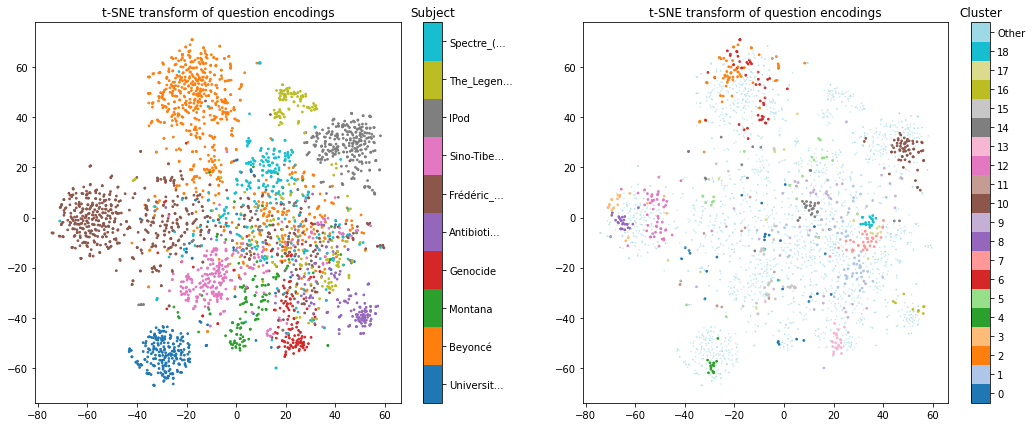

In [34]:
fig,ax=plt.subplots(1,2,figsize=(18,7))


im=ax[0].scatter(x=X_train_tsne[:,0],
                 y=X_train_tsne[:,1],
                 s=3,
                 c=subdataset['subject_id'],
                 cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5)
ax[0].set_title('t-SNE transform of question encodings')
cbar=fig.colorbar(im, ax=ax.ravel()[0], ticks=[*range(10)])
cbar.ax.set_yticklabels([list(subject_dict.keys())[i][:9]+('...' if len(list(subject_dict.keys())[i])>9 else '') for i in range(10)])
cbar.ax.set_title('Subject')

im=ax[1].scatter(x=X_train_tsne[:,0],
                 y=X_train_tsne[:,1],
                 s=[3 if i<19 else 0.1 for i in subdataset['low_label']],
                 c=[i if i<19 else 19 for i in subdataset['low_label']],
                 cmap=plt.cm.tab20, vmin=-0.5, vmax=19.5)
ax[1].set_title('t-SNE transform of question encodings')
cbar=fig.colorbar(im, ax=ax.ravel()[1], ticks=[*range(20)])
cbar.ax.set_yticklabels([str(i) if i<19 else 'Other' for i in range(20)])
cbar.ax.set_title('Cluster')

plt.show()

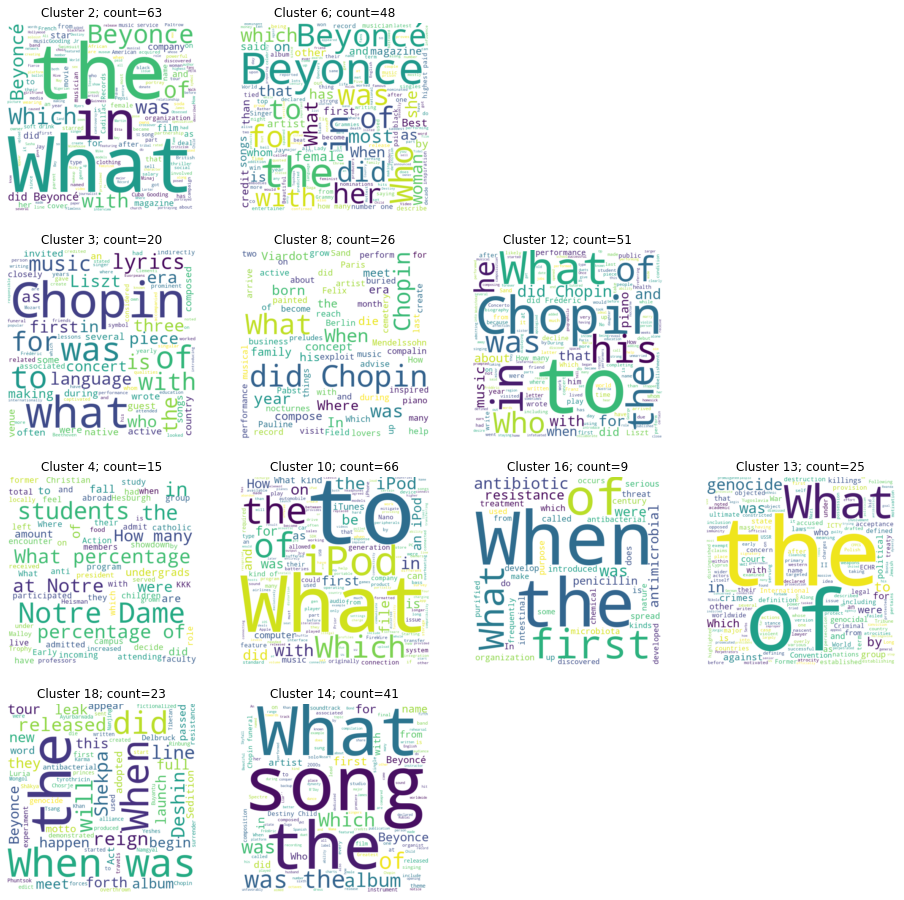

In [36]:
Ks = np.array([np.array([2,6,None,None]), np.array([3,8,12,None]), np.array([4,10,16,13]), np.array([18,14,None,None])])
PlotWordCloudArray(subdataset['question'],subdataset['low_label'],Ks,False,False)

In [37]:
# print clusters
for label in [2,6,3,8,12,4,10,16,13,18,14]:
    display(Markdown("\n**Cluster {0}**:".format(label)))
    qs=subdataset[subdataset['low_label']==label][:10]
    display(Markdown(qs[['low_label','subject','paragraph','question']].to_markdown(index=False)))
    


**Cluster 2**:

|   low_label | subject   | paragraph   | question                                                                      |
|------------:|:----------|:------------|:------------------------------------------------------------------------------|
|           2 | Beyoncé   | Beyoncé_1   | After what movie portraying Etta James, did Beyonce create Sasha Fierce?      |
|           2 | Beyoncé   | Beyoncé_2   | What magazine rated Beyonce as the most powerful female musician in 2015?     |
|           2 | Beyoncé   | Beyoncé_2   | What magazine named Beyoncé as the most powerful female musician for 2015?    |
|           2 | Beyoncé   | Beyoncé_4   | I which church was Beyonce  a member and soloist  in the choir?               |
|           2 | Beyoncé   | Beyoncé_8   | For what network, did Beyonce land a major movie role in?                     |
|           2 | Beyoncé   | Beyoncé_9   | Beyonce starred with Cuba Gooding Jr. in which film?                          |
|           2 | Beyoncé   | Beyoncé_9   | What genre of movie did Beyonce star in with Cuba Gooding, Jr?                |
|           2 | Beyoncé   | Beyoncé_9   | What film did Beyoncé star in with Mike Myers in 2002?                        |
|           2 | Beyoncé   | Beyoncé_9   | What musical comedy did Beyoncé star in along with Cuba Gooding, Jr. in 2003? |
|           2 | Beyoncé   | Beyoncé_11  | Destiny's Child got a star on the Hollywood Walk of Fame in what year?        |


**Cluster 6**:

|   low_label | subject   | paragraph   | question                                                                        |
|------------:|:----------|:------------|:--------------------------------------------------------------------------------|
|           6 | Beyoncé   | Beyoncé_1   | To set the record for Grammys, how many did Beyonce win?                        |
|           6 | Beyoncé   | Beyoncé_2   | Which magazine declared her the most dominant woman musician?                   |
|           6 | Beyoncé   | Beyoncé_5   | What was the name of the first group Beyoncé was a part of?                     |
|           6 | Beyoncé   | Beyoncé_14  | For which decade, did Beyonce have more top ten songs than any other woman?     |
|           6 | Beyoncé   | Beyoncé_14  | Who beat out Beyonce for Best Female Video ?                                    |
|           6 | Beyoncé   | Beyoncé_16  | Beyonce tied with which artist for most nominations by a female artist?         |
|           6 | Beyoncé   | Beyoncé_16  | In 2010, Beyonce worked with which other famous singer?                         |
|           6 | Beyoncé   | Beyoncé_16  | Beyonce tied who for most number one singles by a female?                       |
|           6 | Beyoncé   | Beyoncé_16  | Who did Beyonce tie with for the most nominations in a year?                    |
|           6 | Beyoncé   | Beyoncé_16  | Who did Beyoncé and Lady Gaga tie with for the most number one hits since 1992? |


**Cluster 3**:

|   low_label | subject         | paragraph          | question                                                          |
|------------:|:----------------|:-------------------|:------------------------------------------------------------------|
|           3 | Frédéric_Chopin | Frédéric_Chopin_0  | Chopin was active during what era?                                |
|           3 | Frédéric_Chopin | Frédéric_Chopin_2  | Chopin wrote some music to lyrics, what language were the lyrics? |
|           3 | Frédéric_Chopin | Frédéric_Chopin_2  | Chopin composed several songs to lyrics of what language?         |
|           3 | Frédéric_Chopin | Frédéric_Chopin_2  | Of what venue was Chopin an often invited guest?                  |
|           3 | Frédéric_Chopin | Frédéric_Chopin_3  | Chopin is a native of what country?                               |
|           3 | Frédéric_Chopin | Frédéric_Chopin_3  | Chopin is closely associated with what era?                       |
|           3 | Frédéric_Chopin | Frédéric_Chopin_3  | Chopin was indirectly related to what?                            |
|           3 | Frédéric_Chopin | Frédéric_Chopin_3  | Chopin is considered a prominent symbol of what?                  |
|           3 | Frédéric_Chopin | Frédéric_Chopin_9  | Chopin had three years of lessons with whom?                      |
|           3 | Frédéric_Chopin | Frédéric_Chopin_20 | Chopin gave a yearly performance where?                           |


**Cluster 8**:

|   low_label | subject         | paragraph          | question                                 |
|------------:|:----------------|:-------------------|:-----------------------------------------|
|           8 | Frédéric_Chopin | Frédéric_Chopin_0  | What year was Chopin born?               |
|           8 | Frédéric_Chopin | Frédéric_Chopin_0  | What era was Chopin active during?       |
|           8 | Frédéric_Chopin | Frédéric_Chopin_0  | Where did Chopin grow up?                |
|           8 | Frédéric_Chopin | Frédéric_Chopin_0  | When did Chopin die?                     |
|           8 | Frédéric_Chopin | Frédéric_Chopin_0  | In what year was Chopin born?            |
|           8 | Frédéric_Chopin | Frédéric_Chopin_0  | In what era of music did Chopin compose? |
|           8 | Frédéric_Chopin | Frédéric_Chopin_0  | What year did Chopin die?                |
|           8 | Frédéric_Chopin | Frédéric_Chopin_2  | What concept did Chopin create?          |
|           8 | Frédéric_Chopin | Frédéric_Chopin_4  | Where was Chopin born?                   |
|           8 | Frédéric_Chopin | Frédéric_Chopin_11 | What was the Chopin family's business?   |


**Cluster 12**:

|   low_label | subject         | paragraph          | question                                                                                                            |
|------------:|:----------------|:-------------------|:--------------------------------------------------------------------------------------------------------------------|
|          12 | Frédéric_Chopin | Frédéric_Chopin_1  | During the last 18 years he lived about how many times did Chopin perform in public?                                |
|          12 | Frédéric_Chopin | Frédéric_Chopin_7  | Which sister did Frédéric play duets with sometimes while being tutored at this time?                               |
|          12 | Frédéric_Chopin | Frédéric_Chopin_7  | How old was Chopin when he began to perform for the public?                                                         |
|          12 | Frédéric_Chopin | Frédéric_Chopin_10 | What type of music did Chopin discover for the first time while staying in Szafarnia?                               |
|          12 | Frédéric_Chopin | Frédéric_Chopin_12 | To whom did Chopin reveal in letters which parts of his work were about the singing student he was infatuated with? |
|          12 | Frédéric_Chopin | Frédéric_Chopin_14 | On what date did Frédéric give his first performance of Piano Concerto No. 2 in F minor, Op. 21?                    |
|          12 | Frédéric_Chopin | Frédéric_Chopin_14 | Who did Chopin hear play violin in 1829 that prompted him to write a composisition?                                 |
|          12 | Frédéric_Chopin | Frédéric_Chopin_14 | How many public performances did Chopin do where he made his debut after completing his education?                  |
|          12 | Frédéric_Chopin | Frédéric_Chopin_14 | How many weeks after completing school was it before Chopin made his public debut?                                  |
|          12 | Frédéric_Chopin | Frédéric_Chopin_15 | Who said that Chopin set out "into the wide world, with no very clearly defined aim, forever?"                      |


**Cluster 4**:

|   low_label | subject                  | paragraph                   | question                                                                                  |
|------------:|:-------------------------|:----------------------------|:------------------------------------------------------------------------------------------|
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_8  | How many incoming students did Notre Dame admit in fall 2015?                             |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_8  | What percentage of students were admitted to Notre Dame in fall 2015?                     |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_8  | What percentage of students at Notre Dame participated in the Early Action program?       |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_9  | What percentage of Notre Dame students decide to study abroad?                            |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_15 | How many undergrads were attending Notre Dame in 2014?                                    |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_15 | What percentage of students at Notre Dame are the children of former Notre Dame students? |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_15 | How many students in total were at Notre Dame in 2014?                                    |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_16 | What percentage of undergrads live on the Notre Dame campus?                              |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_17 | What percentage of Notre Dame students feel they are Christian?                           |
|           4 | University_of_Notre_Dame | University_of_Notre_Dame_21 | Notre Dame students had a showdown in 1924 with which anti-catholic group?                |


**Cluster 10**:

|   low_label | subject   | paragraph   | question                                                                                                   |
|------------:|:----------|:------------|:-----------------------------------------------------------------------------------------------------------|
|          10 | IPod      | IPod_3      | Prior to iOS 5, how many apps were required to play music and videos on iPhone and iPad?                   |
|          10 | IPod      | IPod_11     | What kind of headphones could partially mitigate the bass response issues of the 3rd gen iPods?            |
|          10 | IPod      | IPod_11     | What is an example of a device that could entirely mitigate the bass response issues of the 3rd gen iPods? |
|          10 | IPod      | IPod_12     | What acoustic element could be distorted by different audio settings in iPods prior to 2007?               |
|          10 | IPod      | IPod_12     | Name four sound profiles that would result in bass distortion on pre-2007 iPods.                           |
|          10 | IPod      | IPod_13     | What was the limit imposed on how loud the iPod could play sounds in the EU?                               |
|          10 | IPod      | IPod_13     | What country originally pulled iPods due to higher-than-allowed volume levels?                             |
|          10 | IPod      | IPod_14     | What was the first type of connection used by the iPod to charge and transfer files?                       |
|          10 | IPod      | IPod_14     | What type of connector was originally required to upload songs or recharge the iPod?                       |
|          10 | IPod      | IPod_15     | In which generation did iPod start providing compatibility with USB?                                       |


**Cluster 16**:

|   low_label | subject     | paragraph      | question                                                              |
|------------:|:------------|:---------------|:----------------------------------------------------------------------|
|          16 | Antibiotics | Antibiotics_0  | What is the purpose of antibiotic treatment?                          |
|          16 | Antibiotics | Antibiotics_4  | What organization called antimicrobial resistance a 'serious threat?' |
|          16 | Antibiotics | Antibiotics_4  | In which century were antibiotics first introduced?                   |
|          16 | Antibiotics | Antibiotics_7  | When do intestinal microbiota develop?                                |
|          16 | Antibiotics | Antibiotics_10 | When does the spread of antibacterial resistance frequently occurs/   |
|          16 | Antibiotics | Antibiotics_17 | When were some kinds of antimicrobials first used?                    |
|          16 | Antibiotics | Antibiotics_20 | What was the first antibiotic developed from nature?                  |
|          16 | Antibiotics | Antibiotics_21 | When was penicillin G first purified?                                 |
|          16 | Antibiotics | Antibiotics_21 | When was the chemical make-up of penicillin discovered?               |


**Cluster 13**:

|   low_label | subject   | paragraph   | question                                                                                                                                     |
|------------:|:----------|:------------|:---------------------------------------------------------------------------------------------------------------------------------------------|
|          13 | Genocide  | Genocide_0  | What 2001 case was declared genocide by the International Criminal Tribune for the Former Yugoslavia (ICTY)?                                 |
|          13 | Genocide  | Genocide_1  | Which country's courts were noted by the ECHR for taking a wider stance on provisions of genocide laws?                                      |
|          13 | Genocide  | Genocide_2  | Following World War II, whose bid was successful in establishing the worldwide acceptance and the nascent legal definition of genocide?      |
|          13 | Genocide  | Genocide_3  | What is one of the countries that objected to the inclusion of political killings in the early version of the Convention?                    |
|          13 | Genocide  | Genocide_3  | What was the primary concern of other nations who objected to including political groups in the definition of genocide?                      |
|          13 | Genocide  | Genocide_3  | Which distinguished academic of genocide highlighted several other countries opposed to including political genocide in the Convention?      |
|          13 | Genocide  | Genocide_3  | What atrocity motivated a self-serving USSR to object to the provision of political killings drafted into the Convention?                    |
|          13 | Genocide  | Genocide_4  | Which group was accused by the ECHR of having an overly constricted idea of the meaning of destruction in defining genocide?                 |
|          13 | Genocide  | Genocide_6  | Long before genocide was established as a legal term, what treaty was in place to protect various groups from persecution and mass killings? |
|          13 | Genocide  | Genocide_7  | What was the name of the Polish-Jewish lawyer who first described Nazi atrocities as "genocide?"                                             |


**Cluster 18**:

|   low_label | subject   | paragraph   | question                                 |
|------------:|:----------|:------------|:-----------------------------------------|
|          18 | Beyoncé   | Beyoncé_18  | When did this leak happen?               |
|          18 | Beyoncé   | Beyoncé_19  | When was Beyonce's forth album released? |
|          18 | Beyoncé   | Beyoncé_19  | When was 4 released?                     |
|          18 | Beyoncé   | Beyoncé_22  | When did the tour begin?                 |
|          18 | Beyoncé   | Beyoncé_31  | When will they meet?                     |
|          18 | Beyoncé   | Beyoncé_58  | When will the new line launch?           |
|          18 | Beyoncé   | Beyoncé_62  | When will the full line appear?          |
|          18 | Montana   | Montana_3   | When was the motto adopted?              |
|          18 | Montana   | Montana_42  | When was the Sedition Act passed?        |
|          18 | Genocide  | Genocide_7  | When was the word "genocide" first used? |


**Cluster 14**:

|   low_label | subject   | paragraph   | question                                                                    |
|------------:|:----------|:------------|:----------------------------------------------------------------------------|
|          14 | Beyoncé   | Beyoncé_0   | What album made her a worldwide known artist?                               |
|          14 | Beyoncé   | Beyoncé_4   | Who was the first person to notice Beyonce's singing ability?               |
|          14 | Beyoncé   | Beyoncé_4   | What was the name of Beyoncé's first dance instructor?                      |
|          14 | Beyoncé   | Beyoncé_6   | What was Destiny's Child's first major song hit?                            |
|          14 | Beyoncé   | Beyoncé_9   | Which other song from the soundtrack did better in the charts?              |
|          14 | Beyoncé   | Beyoncé_9   | What song was the lead single from the film's sound track?                  |
|          14 | Beyoncé   | Beyoncé_10  | Beyonce's first number one song was which song?                             |
|          14 | Beyoncé   | Beyoncé_10  | Beyonce's first solo album in the U.S. with what artist in the lead single? |
|          14 | Beyoncé   | Beyoncé_10  | Which artist was associated with Beyoncé's premiere solo recording?         |
|          14 | Beyoncé   | Beyoncé_11  | What was the name of the final album of Destiny's Child?                    |

## Hierarchical Clustering

In [46]:
from sklearn.cluster import AgglomerativeClustering

from dendrogram import plot_dendrogram

In [43]:
# perform vanilla hierarchical clustering (ward)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_train)

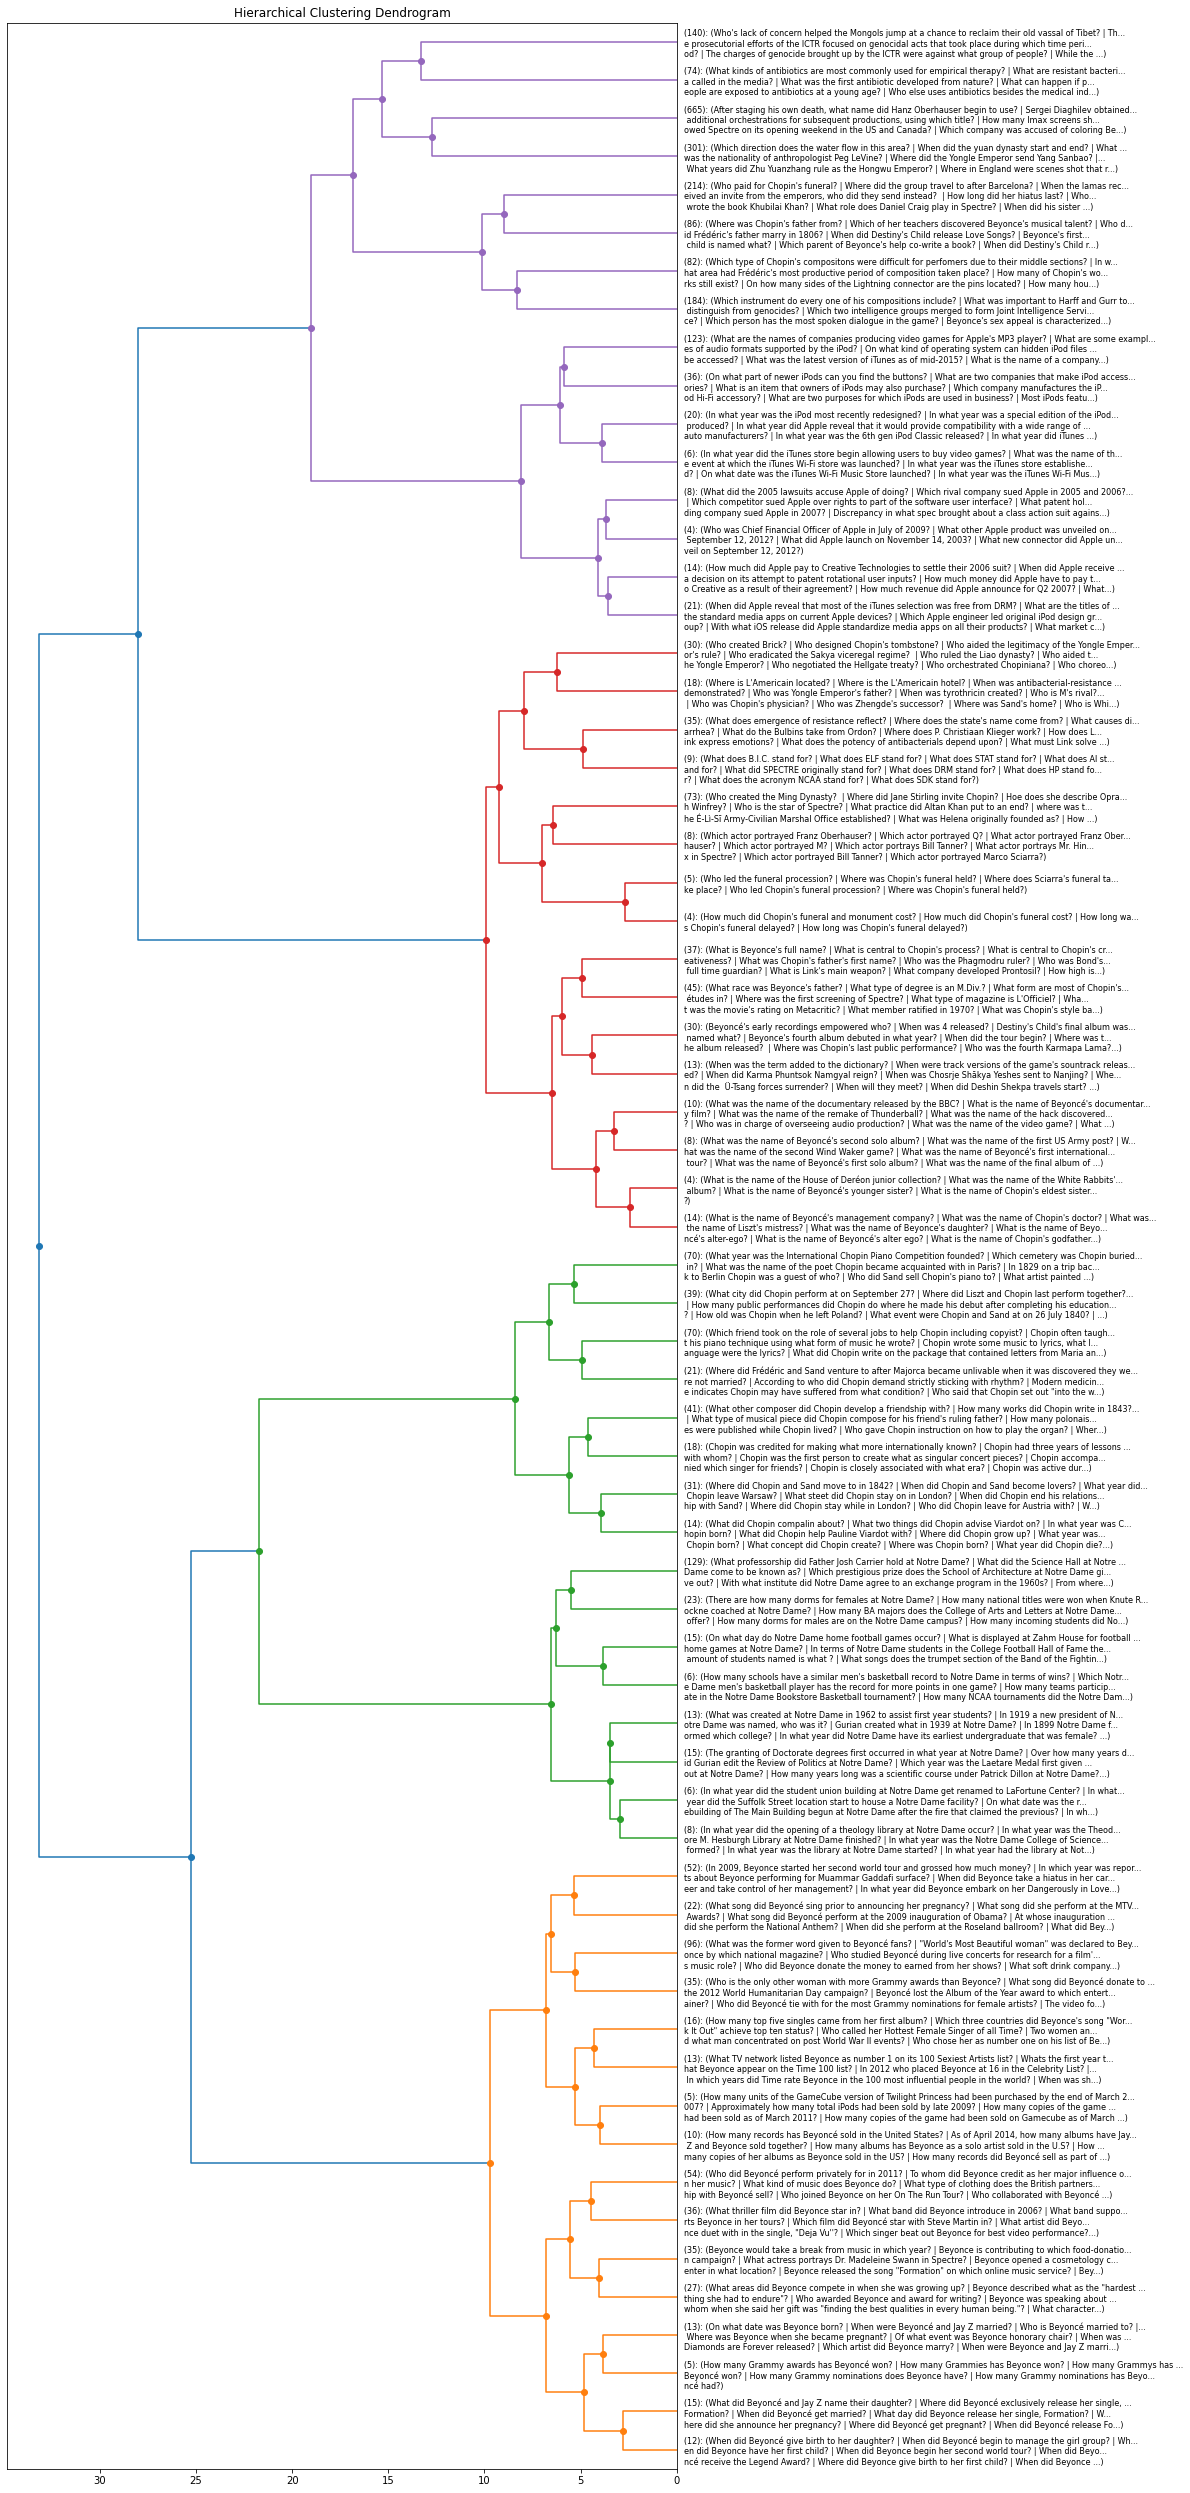

In [109]:
# set level of clustering
level=5

# plot the top three levels of the dendrogram
plt.figure(figsize=(12,1.8*max(level**2,4)))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, 
                questions=subdataset['question'],
                truncate_mode='level', 
                leaf_font_size=8,
                p=level,
                orientation='left')
plt.show()